In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score, log_loss, roc_auc_score
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

e:\Bootcamp\NLP_Grupo3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def procesar_texto(text):
    '''
    1. El texto se pasa todo a minúsculas
    2. Se eliminan todos los símbolos que pueden dar problemas
    3. Se tokeniza el texto
    4. Se eliminan las stop_words, básicamente preposiciones o palabras que no aportan contenido semántico, a excepción de las negaciones porque pueden dar información conrextual relevante.
    5. Se convierten los tokens mediantes stemming, que se queda con la raiz o "lema" de una palabra para mejorar el rendimiento
    '''
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

def text_to_embedding(tokens, embeddings_index, embedding_dim=100):
    '''
    1. Se inicializa el embedding (vector) vacío pero con las dimensiones especificadas (100, que coincide con las dimensiones de los embeddings descargados)
    Este vector guarda el sumatorio acumulado de cada embedding individual de cada palabra (de 100 dimensiones también), que representará el texto completo.
    2. Se inicia un conteo a 0, este conteo servirá para contar cuantos embeddings válidos encontramos en el índice, y si no hay se mantiene a 0 para prevenir errores futuros al dividir.
    3. Se itera sobre la lista de tokens del texto y si se encuentra el token en el índice de embeddings, se añade el vector de la palabra al vector de embedding. Cada vez que encuentra una válido se suma 1 al conteo.
    4. Por último se saca la media del embedding con el número de conteo para que las palabras más representadas en un texto no dominen el embedding final.
    '''
    embedding = np.zeros(embedding_dim)
    count = 0
    for token in tokens:
        if token in embeddings_index:
            embedding += embeddings_index[token]
            count += 1
    if count > 0:
        embedding /= count
    return embedding



In [3]:
def validation_score(model, X, y):
    # Dividir el conjunto en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenar el modelo en el conjunto de entrenamiento
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de validación
    y_pred = model.predict(X_val)
    
    # Calcular la métrica F1
    score = f1_score(y_val, y_pred, average="binary")  # Utilizar "binary" si es un problema binario
    return score

In [ ]:
class MultiHeadHateClassifier:
    def __init__(self):
        self.models = {}
        self.label_columns = ['IsAbusive', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist']
        self.embeddings_index = None

    def optimize_model(self, X, y, column):
        """
        Realiza una búsqueda de hiperparámetros con Optuna para el modelo de una columna específica.
        """
        pos_weight = (y[column] == 0).sum() / (y[column] == 1).sum()

        def objective(trial):
            # Espacio de búsqueda para los hiperparámetros de XGBClassifier
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'gamma': trial.suggest_float('gamma', 1e-6, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 10.0, log=True),
                'scale_pos_weight': pos_weight
            }
            
            model = XGBClassifier(**params)
            model.fit(X, y[column])
            
            score = validation_score(model, X, y[column])
            return score

        # Crear el estudio Optuna
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)
        
        # Guardar el mejor modelo en self.models
        best_params = study.best_params
        best_params['scale_pos_weight'] = pos_weight
        best_model = XGBClassifier(**best_params)
        best_model.fit(X, y[column])
        
        return best_model

    def fit(self, X, y):
        for column in self.label_columns:
            print(f"Optimizing model for {column}")
            model = self.optimize_model(X, y, column)
            self.models[column] = model
            
    def predict(self, X):
        predictions = {}
        for column in self.label_columns:
            predictions[column] = self.models[column].predict(X)

        final_prediction = np.any(list(predictions.values()), axis=0)
        return final_prediction, predictions
    
    def load_embeddings(self, file_path):
        self.embeddings_index = {}
        with open(file_path, encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs

    def preprocess_text(self, text):
        tokens = procesar_texto(text)
        embedding = text_to_embedding(tokens, self.embeddings_index, 100)
        return np.array([embedding])

In [59]:
classifier = MultiHeadHateClassifier()
classifier.load_embeddings('glove.twitter.27B.100d.txt')

df = pd.read_csv('toxic.csv')

# Definimos el umbral
threshold = 0.05

# Seleccionamos las columnas que queremos analizar (todas menos 'Text', 'CommentId', y 'VideoId')
columns_to_check = df.loc[:, ~df.columns.isin(['Text', 'CommentId', 'VideoId'])]

# Filtramos las columnas cuyo promedio sea mayor o igual al umbral
columns_above_threshold = columns_to_check.columns[columns_to_check.mean() >= threshold]

# Seleccionamos todas las columnas que queremos conservar
columns_to_keep = ['Text', 'CommentId', 'VideoId'] + list(columns_above_threshold)

# Filtramos el DataFrame con las columnas que cumplen con los criterios
df_filtered = df[columns_to_keep]


In [60]:
X = np.array([classifier.preprocess_text(text)[0] for text in df_filtered['Text']])
y = df_filtered[list(columns_above_threshold)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [61]:
classifier.fit(X_train, y_train)

# Make predictions
toxic_pred, type_predictions = classifier.predict(X_test)

[I 2024-11-13 19:06:11,147] A new study created in memory with name: no-name-77f55fbb-7a11-4e24-b7c7-533d69bc9a73


Optimizing model for IsAbusive


[I 2024-11-13 19:06:13,281] Trial 0 finished with value: 0.5106382978723404 and parameters: {'n_estimators': 255, 'learning_rate': 0.002301448406262712, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 4.4014106929827015e-06, 'subsample': 0.7977035493831268, 'colsample_bytree': 0.9831915778550745, 'reg_alpha': 6.4158042747824195, 'reg_lambda': 0.0007026590936306572}. Best is trial 0 with value: 0.5106382978723404.
[I 2024-11-13 19:06:15,591] Trial 1 finished with value: 0.5555555555555556 and parameters: {'n_estimators': 432, 'learning_rate': 0.000648086163513721, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.9283726147097274, 'subsample': 0.881691579262698, 'colsample_bytree': 0.5031288265392895, 'reg_alpha': 0.003289748463542902, 'reg_lambda': 3.748851506051634e-06}. Best is trial 1 with value: 0.5555555555555556.
[I 2024-11-13 19:06:16,856] Trial 2 finished with value: 0.45714285714285713 and parameters: {'n_estimators': 116, 'learning_rate': 0.00010864828628062551, 'max_depth': 

Optimizing model for IsProvocative


[I 2024-11-13 19:09:22,645] Trial 0 finished with value: 0.26666666666666666 and parameters: {'n_estimators': 339, 'learning_rate': 0.0010955071484018413, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 6.760636685848581e-06, 'subsample': 0.8263173099455454, 'colsample_bytree': 0.8832530587834193, 'reg_alpha': 1.3565731215205702e-06, 'reg_lambda': 0.00026551563925110227}. Best is trial 0 with value: 0.26666666666666666.
[I 2024-11-13 19:09:23,899] Trial 1 finished with value: 0.14285714285714285 and parameters: {'n_estimators': 227, 'learning_rate': 0.08306392200493413, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.047659306694522945, 'subsample': 0.8602462934759985, 'colsample_bytree': 0.7870943958350567, 'reg_alpha': 5.414814410205065e-05, 'reg_lambda': 0.005383450723870461}. Best is trial 0 with value: 0.26666666666666666.
[I 2024-11-13 19:09:26,951] Trial 2 finished with value: 0.3 and parameters: {'n_estimators': 317, 'learning_rate': 0.0013722564994455917, 'max_depth': 7, 'mi

Optimizing model for IsObscene


[I 2024-11-13 19:11:03,039] Trial 0 finished with value: 0.2222222222222222 and parameters: {'n_estimators': 125, 'learning_rate': 0.022846262039510224, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 2.3168397087423394e-05, 'subsample': 0.6780464859717159, 'colsample_bytree': 0.7581087076392239, 'reg_alpha': 0.0022354161213940533, 'reg_lambda': 6.638759446314388e-06}. Best is trial 0 with value: 0.2222222222222222.
[I 2024-11-13 19:11:04,005] Trial 1 finished with value: 0.21052631578947367 and parameters: {'n_estimators': 197, 'learning_rate': 0.08857856314095006, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.0006405648779353384, 'subsample': 0.7439293623968901, 'colsample_bytree': 0.6757952787204815, 'reg_alpha': 1.0672877285631717, 'reg_lambda': 4.2373183631645155}. Best is trial 0 with value: 0.2222222222222222.
[I 2024-11-13 19:11:07,857] Trial 2 finished with value: 0.21052631578947367 and parameters: {'n_estimators': 473, 'learning_rate': 0.006401246795069331, 'max_depth': 

Optimizing model for IsHatespeech


[I 2024-11-13 19:13:13,925] Trial 0 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 321, 'learning_rate': 0.0009140556142475902, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 3.0678602235327945e-05, 'subsample': 0.6303367027085133, 'colsample_bytree': 0.6423084675099304, 'reg_alpha': 0.00034230366690038937, 'reg_lambda': 0.4137219734862754}. Best is trial 0 with value: 0.2857142857142857.
[I 2024-11-13 19:13:15,333] Trial 1 finished with value: 0.3076923076923077 and parameters: {'n_estimators': 247, 'learning_rate': 0.002630615464727409, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 1.0245746917270576e-06, 'subsample': 0.6321230599786237, 'colsample_bytree': 0.7833550620803087, 'reg_alpha': 7.972146270058761, 'reg_lambda': 0.15927845197200619}. Best is trial 1 with value: 0.3076923076923077.
[I 2024-11-13 19:13:17,641] Trial 2 finished with value: 0.3157894736842105 and parameters: {'n_estimators': 393, 'learning_rate': 0.005086488867250524, 'max_depth': 6

Optimizing model for IsRacist


[I 2024-11-13 19:15:30,192] Trial 0 finished with value: 0.34146341463414637 and parameters: {'n_estimators': 452, 'learning_rate': 0.001422839145498857, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.000244976439119288, 'subsample': 0.7871708104312757, 'colsample_bytree': 0.8235661868402349, 'reg_alpha': 0.44310434919766645, 'reg_lambda': 5.651031210415185e-05}. Best is trial 0 with value: 0.34146341463414637.
[I 2024-11-13 19:15:33,936] Trial 1 finished with value: 0.3076923076923077 and parameters: {'n_estimators': 448, 'learning_rate': 0.003071245858046917, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.0007604917272759481, 'subsample': 0.5344908641138675, 'colsample_bytree': 0.7165079873260878, 'reg_alpha': 0.04649924921741851, 'reg_lambda': 0.00011958295021831139}. Best is trial 0 with value: 0.34146341463414637.
[I 2024-11-13 19:15:34,655] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_estimators': 123, 'learning_rate': 0.001356241276379205, 'max_depth

Accuracy: 0.67
Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.72      0.71       166
        True       0.64      0.61      0.62       134

    accuracy                           0.67       300
   macro avg       0.67      0.66      0.66       300
weighted avg       0.67      0.67      0.67       300



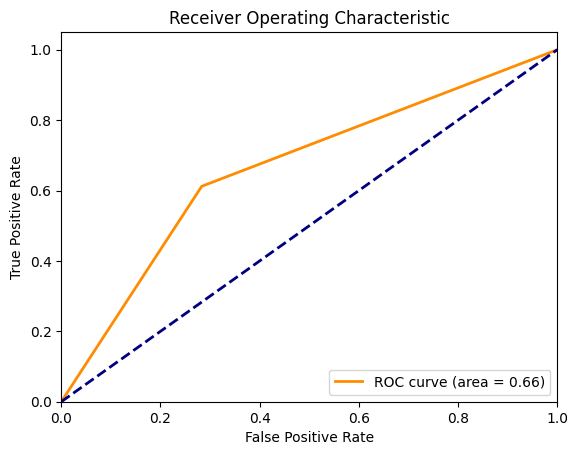

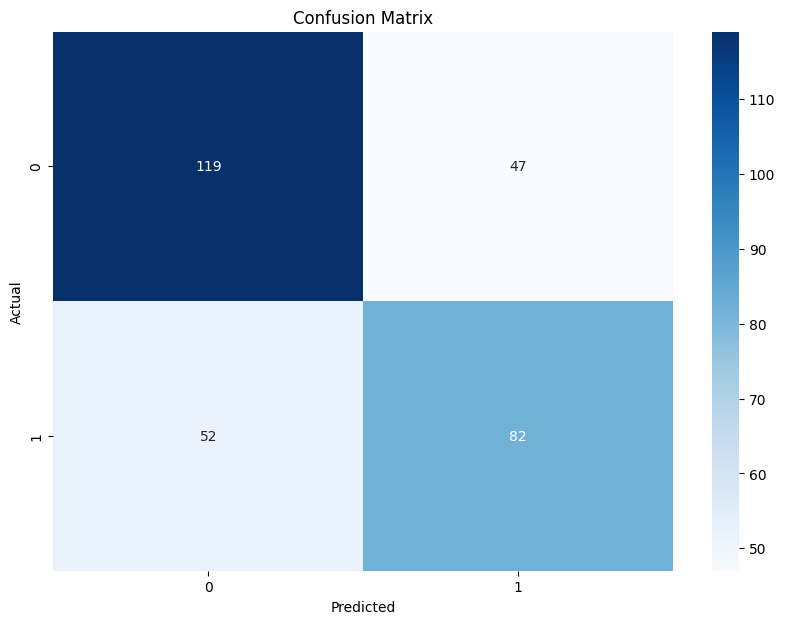

TypeError: Cannot clone object '<__main__.MultiHeadHateClassifier object at 0x0000025D506B2AE0>' (type <class '__main__.MultiHeadHateClassifier'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [62]:
print("Accuracy:", accuracy_score(y_test.any(axis=1), toxic_pred))
print("Classification Report:\n", classification_report(y_test.any(axis=1), toxic_pred))

# 2. Curva ROC
fpr, tpr, _ = roc_curve(y_test.any(axis=1), toxic_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. Matriz de Confusión
conf_matrix = confusion_matrix(y_test.any(axis=1), toxic_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

skf = StratifiedKFold(n_splits=5)
cross_val_scores = cross_val_score(classifier, X, y.any(axis=1), cv=skf, scoring='accuracy')
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", np.mean(cross_val_scores))

In [66]:
texto_prueba = 'I love black people'
processed_text = classifier.preprocess_text(texto_prueba)
processed_text = np.array([processed_text[0]])

is_toxic, toxicity_types = classifier.predict(processed_text)

# Mostrar resultados
print("¿Es tóxico?:", is_toxic[0])
print("Predicciones por tipo de toxicidad:")
for toxicity_type, prediction in toxicity_types.items():
    print(f"{toxicity_type}: {prediction[0]}")

¿Es tóxico?: True
Predicciones por tipo de toxicidad:
IsAbusive: 0
IsProvocative: 0
IsObscene: 0
IsHatespeech: 1
IsRacist: 1


# Multihead con stacking logistico

In [127]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

class MultiHeadHateClassifier_2:
    def __init__(self):
        self.models_random_forest = {}
        self.models_xgboost = {}
        self.label_columns = ['IsAbusive', 'IsProvocative', 'IsHatespeech', 'IsRacist']
        self.embeddings_index = None
        # Add SMOTE for handling imbalanced data
        self.smote = SMOTE(random_state=42)
        # Add cross-validation
        self.cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    def optimize_random_forest_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Increased range
                'max_depth': trial.suggest_int('max_depth', 5, 30),          # Increased range
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
                'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                # Apply SMOTE only on training data
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = RandomForestClassifier(**params)
                model.fit(X_train_resampled, y_train_resampled)
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)  # Increased trials
        
        # Get best parameters and train final model
        best_params = study.best_params
        best_model = RandomForestClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model
    
    def optimize_xgboost_model(self, X, y, column):
        X_array = np.array(X)
        y_array = np.array(y[column])
        pos_weight = (y_array == 0).sum() / (y_array == 1).sum()

        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
                'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                'scale_pos_weight': pos_weight,
                'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
                'tree_method': 'hist'  # For faster training
            }
            
            scores = []
            for train_idx, val_idx in self.cv.split(X_array, y_array):
                X_train, X_val = X_array[train_idx], X_array[val_idx]
                y_train, y_val = y_array[train_idx], y_array[val_idx]
                
                X_train_resampled, y_train_resampled = self.smote.fit_resample(X_train, y_train)
                
                model = XGBClassifier(**params,  early_stopping_rounds=20)
                model.fit(
                    X_train_resampled, 
                    y_train_resampled,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
                y_pred = model.predict(X_val)
                scores.append(f1_score(y_val, y_pred))
            
            return np.mean(scores)

        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=75)  # Increased trials
        
        best_params = study.best_params
        best_model = XGBClassifier(**best_params)
        X_resampled, y_resampled = self.smote.fit_resample(X_array, y_array)
        best_model.fit(X_resampled, y_resampled)
        return best_model

    def fit(self, X, y):
        X = np.array(X)
        
        for column in self.label_columns:
            print(f"Optimizing Random Forest model for {column}")
            best_randomforest_model = self.optimize_random_forest_model(X, y, column)
            self.models_random_forest[column] = best_randomforest_model
            
            print(f"Optimizing XGBoost model for {column}")
            best_xgboost_model = self.optimize_xgboost_model(X, y, column)
            self.models_xgboost[column] = best_xgboost_model
            
    def predict(self, X):
        # Ensure X is a numpy array
        X = np.array(X)
        
        predictions = {column: {
            'rf_prob': self.models_random_forest[column].predict_proba(X)[:, 1],
            'xgb_prob': self.models_xgboost[column].predict_proba(X)[:, 1]
        } for column in self.label_columns}
        
        final_predictions = []
        for column in self.label_columns:
            rf_weight = 0.4
            xgb_weight = 0.6
            
            combined_preds = (
                (rf_weight * predictions[column]['rf_prob']) + 
                (xgb_weight * predictions[column]['xgb_prob'])
            )
            final_predictions.append(combined_preds > 0.5)
        
        final_predictions = np.array(final_predictions).T
        return np.any(final_predictions, axis=1)
    
    def load_embeddings(self, file_path):
        # Load GloVe embeddings
        self.embeddings_index = {}
        with open(file_path, encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
                
    def preprocess_text(self, text):
        """Text preprocessing as defined in notebook"""
        tokens = procesar_texto(text) # Using existing function
        embedding = text_to_embedding(tokens, self.embeddings_index, 100)
        return np.array([embedding])

In [128]:
classifier = MultiHeadHateClassifier_2()
classifier.load_embeddings('glove.twitter.27B.100d.txt')

In [129]:
df = pd.read_csv('toxic.csv')
threshold = 0.11

# Filter relevant columns
columns_to_check = df.loc[:, ~df.columns.isin(['Text', 'CommentId', 'VideoId'])]
columns_above_threshold = columns_to_check.columns[columns_to_check.mean() >= threshold]
columns_to_keep = ['Text', 'CommentId', 'VideoId'] + list(columns_above_threshold)
df_filtered = df[columns_to_keep]

In [130]:
X = np.array([classifier.preprocess_text(text)[0] for text in df_filtered['Text']])
y = df_filtered[list(columns_above_threshold)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [131]:
classifier.fit(X_train, y_train)

[I 2024-11-14 01:31:54,224] A new study created in memory with name: no-name-5a13710c-ea66-458b-8bf5-cb4f3cc987bd


Optimizing Random Forest model for IsAbusive


[I 2024-11-14 01:34:14,809] Trial 0 finished with value: 0.5550175665163584 and parameters: {'n_estimators': 484, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5550175665163584.
[I 2024-11-14 01:34:27,436] Trial 1 finished with value: 0.5396959682749504 and parameters: {'n_estimators': 451, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 0 with value: 0.5550175665163584.
[I 2024-11-14 01:37:17,332] Trial 2 finished with value: 0.4596931060032009 and parameters: {'n_estimators': 497, 'max_depth': 28, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 0 with value: 0.5550175665163584.
[I 2024-11

Optimizing XGBoost model for IsAbusive


[I 2024-11-14 01:55:02,596] Trial 0 finished with value: 0.5294020391292367 and parameters: {'n_estimators': 526, 'learning_rate': 0.0001522279996537035, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 0.02981045445108778, 'subsample': 0.7350401902674963, 'colsample_bytree': 0.6557245171509498, 'reg_alpha': 2.242881187110304e-06, 'reg_lambda': 1.290822645730119e-05, 'max_delta_step': 7}. Best is trial 0 with value: 0.5294020391292367.
[I 2024-11-14 01:55:32,323] Trial 1 finished with value: 0.5671112496370083 and parameters: {'n_estimators': 719, 'learning_rate': 0.0010345325943056389, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.9220177471990845, 'subsample': 0.6577191612485229, 'colsample_bytree': 0.7816556554072518, 'reg_alpha': 5.334956546241414e-08, 'reg_lambda': 0.2213957058607528, 'max_delta_step': 0}. Best is trial 1 with value: 0.5671112496370083.
[I 2024-11-14 01:55:38,156] Trial 2 finished with value: 0.5572296963348886 and parameters: {'n_estimators': 365, 'learning_r

Optimizing Random Forest model for IsProvocative


[I 2024-11-14 02:05:15,568] Trial 0 finished with value: 0.3032759509993552 and parameters: {'n_estimators': 419, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 0 with value: 0.3032759509993552.
[I 2024-11-14 02:05:29,281] Trial 1 finished with value: 0.2746499323243509 and parameters: {'n_estimators': 317, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.3032759509993552.
[I 2024-11-14 02:05:40,309] Trial 2 finished with value: 0.26574770258980784 and parameters: {'n_estimators': 333, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini'}. Best is trial 0 with value: 0.3032759509993552.
[I 2024-1

Optimizing XGBoost model for IsProvocative


[I 2024-11-14 02:46:06,257] Trial 0 finished with value: 0.3190367726216783 and parameters: {'n_estimators': 131, 'learning_rate': 0.28272475814194875, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 5.965479236730663e-06, 'subsample': 0.7887860997283562, 'colsample_bytree': 0.7805792619926595, 'reg_alpha': 0.8057104030994114, 'reg_lambda': 0.012646895935171522, 'max_delta_step': 3}. Best is trial 0 with value: 0.3190367726216783.
[I 2024-11-14 02:46:10,287] Trial 1 finished with value: 0.2800878588199651 and parameters: {'n_estimators': 231, 'learning_rate': 0.00011359125871859153, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 0.0725085090970805, 'subsample': 0.8189617341981213, 'colsample_bytree': 0.5277669500464961, 'reg_alpha': 9.632361302895464e-08, 'reg_lambda': 5.862283193073915e-06, 'max_delta_step': 4}. Best is trial 0 with value: 0.3190367726216783.
[I 2024-11-14 02:46:26,754] Trial 2 finished with value: 0.2800878588199651 and parameters: {'n_estimators': 698, 'learning_r

Optimizing Random Forest model for IsHatespeech


[I 2024-11-14 02:51:47,865] Trial 0 finished with value: 0.2588647998384307 and parameters: {'n_estimators': 423, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 0 with value: 0.2588647998384307.
[I 2024-11-14 02:52:12,741] Trial 1 finished with value: 0.28466338259441704 and parameters: {'n_estimators': 313, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 1 with value: 0.28466338259441704.
[I 2024-11-14 02:52:21,520] Trial 2 finished with value: 0.30997920254411204 and parameters: {'n_estimators': 393, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 2 with value: 0.30997920254411204.
[I 2024-11-14 02:52:

Optimizing XGBoost model for IsHatespeech


[I 2024-11-14 03:55:26,081] Trial 0 finished with value: 0.3948744588744589 and parameters: {'n_estimators': 563, 'learning_rate': 0.036060667278937204, 'max_depth': 15, 'min_child_weight': 3, 'gamma': 1.779989568506551e-06, 'subsample': 0.5687375820346524, 'colsample_bytree': 0.7661303561575585, 'reg_alpha': 0.017927949270320785, 'reg_lambda': 0.03816034923345581, 'max_delta_step': 6}. Best is trial 0 with value: 0.3948744588744589.
[I 2024-11-14 03:55:56,288] Trial 1 finished with value: 0.3880577775149906 and parameters: {'n_estimators': 874, 'learning_rate': 0.002045882989228593, 'max_depth': 14, 'min_child_weight': 4, 'gamma': 0.007707441555807846, 'subsample': 0.6916144038667791, 'colsample_bytree': 0.648318349275359, 'reg_alpha': 2.937528105311088e-07, 'reg_lambda': 0.0073730157152559405, 'max_delta_step': 0}. Best is trial 0 with value: 0.3948744588744589.
[I 2024-11-14 03:55:58,979] Trial 2 finished with value: 0.24339622641509434 and parameters: {'n_estimators': 109, 'learnin

Optimizing Random Forest model for IsRacist


[I 2024-11-14 04:03:11,625] Trial 0 finished with value: 0.3507083554142378 and parameters: {'n_estimators': 271, 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy'}. Best is trial 0 with value: 0.3507083554142378.
[I 2024-11-14 04:03:27,935] Trial 1 finished with value: 0.35763538263538264 and parameters: {'n_estimators': 409, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'entropy'}. Best is trial 1 with value: 0.35763538263538264.
[I 2024-11-14 04:03:36,936] Trial 2 finished with value: 0.33731968577469423 and parameters: {'n_estimators': 282, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini'}. Best is trial 1 with value: 0.35763538263538264.
[I 2024-11-14 04:06:12,0

Optimizing XGBoost model for IsRacist


[I 2024-11-14 04:19:45,330] Trial 0 finished with value: 0.3991092702056157 and parameters: {'n_estimators': 280, 'learning_rate': 0.04616117585607543, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 2.8259023897716066e-05, 'subsample': 0.5386306656449199, 'colsample_bytree': 0.5742492045062233, 'reg_alpha': 6.681374955196568e-07, 'reg_lambda': 8.213372578739427e-06, 'max_delta_step': 10}. Best is trial 0 with value: 0.3991092702056157.
[I 2024-11-14 04:20:01,735] Trial 1 finished with value: 0.24376640603141236 and parameters: {'n_estimators': 934, 'learning_rate': 0.0007255278717752096, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 6.52294365800024e-07, 'subsample': 0.6342523206216055, 'colsample_bytree': 0.949705153661456, 'reg_alpha': 7.330804762827307e-06, 'reg_lambda': 1.0854074717343993, 'max_delta_step': 3}. Best is trial 0 with value: 0.3991092702056157.
[I 2024-11-14 04:20:17,250] Trial 2 finished with value: 0.2233330645811497 and parameters: {'n_estimators': 647, 'learnin

Accuracy: 0.6866666666666666
Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.70      0.71       166
        True       0.64      0.67      0.66       134

    accuracy                           0.69       300
   macro avg       0.68      0.69      0.68       300
weighted avg       0.69      0.69      0.69       300



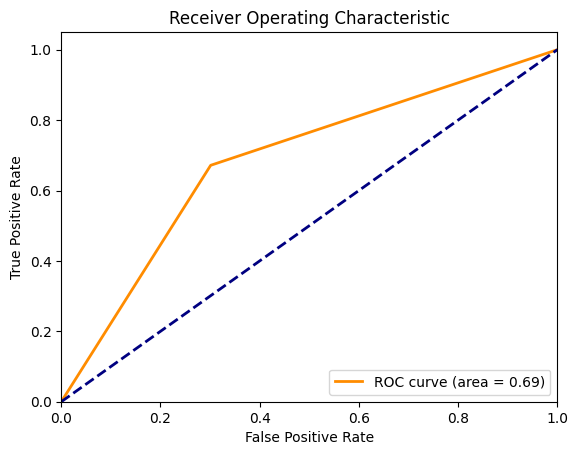

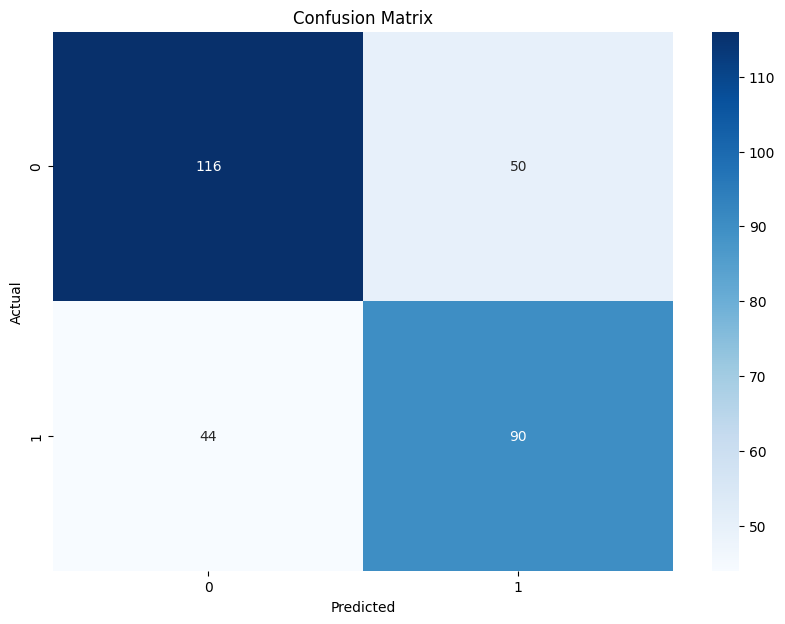

In [132]:
toxic_pred = classifier.predict(X_test)

# Mostrar resultados
print("Accuracy:", accuracy_score(y_test.any(axis=1), toxic_pred))
print("Classification Report:\n", classification_report(y_test.any(axis=1), toxic_pred))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test.any(axis=1), toxic_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test.any(axis=1), toxic_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [133]:
# Validación Cruzada
skf = StratifiedKFold(n_splits=5)
cross_val_scores = cross_val_score(classifier.models_xgboost['IsAbusive'], X, y['IsAbusive'], cv=skf, scoring='accuracy')
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", np.mean(cross_val_scores))

Cross-validation scores: [0.74  0.715 0.73  0.75  0.675]
Mean cross-validation score: 0.7220000000000001


In [134]:
import pickle

def guardar_modelo(modelo, nombre_archivo):
    """
    Guarda el modelo entrenado en un archivo .pkl

    Args:
    modelo: El modelo entrenado que se desea guardar.
    nombre_archivo: El nombre del archivo donde se guardará el modelo.
    """
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(modelo, archivo)
    print(f"Modelo guardado en {nombre_archivo}")

guardar_modelo(classifier, 'multihead_hate_classifier.pkl')

Modelo guardado en multihead_hate_classifier.pkl


In [136]:
texto_prueba = 'I love black people'
processed_text = classifier.preprocess_text(texto_prueba)
processed_text = np.array([processed_text[0]])

is_toxic = classifier.predict(processed_text)

# Mostrar resultados
print("¿Es tóxico?:", is_toxic[0])

¿Es tóxico?: True


Versión usando BERT

In [4]:
from transformers import BertTokenizer, BertModel
import torch

df = pd.read_csv('../database/toxic.csv')

In [14]:
class MultiHeadHateClassifier:
    def __init__(self):
        self.models = {}
        self.label_columns = ['IsAbusive', 'IsProvocative', 'IsHatespeech', 'IsRacist']
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

    def optimize_model(self, X, y, column):
        """
        Realiza una búsqueda de hiperparámetros con Optuna para el modelo de una columna específica.
        """
        pos_weight = (y[column] == 0).sum() / (y[column] == 1).sum()

        def objective(trial):
            # Espacio de búsqueda para los hiperparámetros de XGBClassifier
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 200),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 3, 6),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                'scale_pos_weight': pos_weight
            }

            model = XGBClassifier(**params)
            model.fit(X, y[column])

            score = validation_score(model, X, y[column])
            return score

        # Crear el estudio Optuna
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=25)

        # Guardar el mejor modelo en self.models
        best_params = study.best_params
        best_params['scale_pos_weight'] = pos_weight
        best_model = XGBClassifier(**best_params)
        best_model.fit(X, y[column])

        return best_model

    def fit(self, X, y):
        for column in self.label_columns:
            print(f"Optimizing model for {column}")
            model = self.optimize_model(X, y, column)
            self.models[column] = model

    def predict(self, X):
        predictions = {}
        for column in self.label_columns:
            predictions[column] = self.models[column].predict(X)

        final_prediction = np.any(list(predictions.values()), axis=0)
        return final_prediction, predictions

    def preprocess_text(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).numpy()
        return embedding

In [15]:
classifier = MultiHeadHateClassifier()

In [16]:
threshold = 0.11

# Filter relevant columns
columns_to_check = df.loc[:, ~df.columns.isin(['Text', 'CommentId', 'VideoId'])]
columns_above_threshold = columns_to_check.columns[columns_to_check.mean() >= threshold]
columns_to_keep = ['Text', 'CommentId', 'VideoId'] + list(columns_above_threshold)
df_filtered = df[columns_to_keep]

In [17]:
X = np.array([classifier.preprocess_text(text)[0] for text in df_filtered['Text']])
y = df_filtered[list(columns_above_threshold)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [18]:
classifier.fit(X_train, y_train)

[I 2024-11-17 23:41:59,689] A new study created in memory with name: no-name-f627852a-1a88-41da-82b3-f91579afe1bf


Optimizing model for IsAbusive


[I 2024-11-17 23:42:05,832] Trial 0 finished with value: 0.5348837209302325 and parameters: {'n_estimators': 118, 'learning_rate': 0.028905029195296902, 'max_depth': 5, 'subsample': 0.738986419355376, 'colsample_bytree': 0.7000715277745608}. Best is trial 0 with value: 0.5348837209302325.
[I 2024-11-17 23:42:11,583] Trial 1 finished with value: 0.49411764705882355 and parameters: {'n_estimators': 177, 'learning_rate': 0.08284896681158752, 'max_depth': 4, 'subsample': 0.7989365558264577, 'colsample_bytree': 0.7679684970134977}. Best is trial 0 with value: 0.5348837209302325.
[I 2024-11-17 23:42:23,990] Trial 2 finished with value: 0.475 and parameters: {'n_estimators': 199, 'learning_rate': 0.048080411115834325, 'max_depth': 6, 'subsample': 0.8414123964053735, 'colsample_bytree': 0.8558622640983625}. Best is trial 0 with value: 0.5348837209302325.
[I 2024-11-17 23:42:28,708] Trial 3 finished with value: 0.5411764705882353 and parameters: {'n_estimators': 116, 'learning_rate': 0.04349098

Optimizing model for IsProvocative


[I 2024-11-17 23:44:28,945] Trial 0 finished with value: 0.37037037037037035 and parameters: {'n_estimators': 185, 'learning_rate': 0.08170657110179752, 'max_depth': 3, 'subsample': 0.7828559720898083, 'colsample_bytree': 0.7433073408521376}. Best is trial 0 with value: 0.37037037037037035.
[I 2024-11-17 23:44:31,507] Trial 1 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 107, 'learning_rate': 0.07632352417271115, 'max_depth': 3, 'subsample': 0.7293506300799764, 'colsample_bytree': 0.903665256122102}. Best is trial 0 with value: 0.37037037037037035.
[I 2024-11-17 23:44:35,557] Trial 2 finished with value: 0.36363636363636365 and parameters: {'n_estimators': 171, 'learning_rate': 0.030512230044432515, 'max_depth': 3, 'subsample': 0.8555004125353289, 'colsample_bytree': 0.7367805433572516}. Best is trial 0 with value: 0.37037037037037035.
[I 2024-11-17 23:44:43,719] Trial 3 finished with value: 0.38461538461538464 and parameters: {'n_estimators': 162, 'learning_

Optimizing model for IsHatespeech


[I 2024-11-17 23:46:51,738] Trial 0 finished with value: 0.2857142857142857 and parameters: {'n_estimators': 106, 'learning_rate': 0.04009722325078964, 'max_depth': 5, 'subsample': 0.9671607113024522, 'colsample_bytree': 0.9542018108801638}. Best is trial 0 with value: 0.2857142857142857.
[I 2024-11-17 23:46:56,145] Trial 1 finished with value: 0.23076923076923078 and parameters: {'n_estimators': 185, 'learning_rate': 0.07835317059099874, 'max_depth': 3, 'subsample': 0.8361139377393623, 'colsample_bytree': 0.8576734227689403}. Best is trial 0 with value: 0.2857142857142857.
[I 2024-11-17 23:47:00,426] Trial 2 finished with value: 0.2962962962962963 and parameters: {'n_estimators': 169, 'learning_rate': 0.08783096763594417, 'max_depth': 3, 'subsample': 0.9747817681288324, 'colsample_bytree': 0.901238534421128}. Best is trial 2 with value: 0.2962962962962963.
[I 2024-11-17 23:47:06,984] Trial 3 finished with value: 0.25 and parameters: {'n_estimators': 189, 'learning_rate': 0.04991739809

Optimizing model for IsRacist


[I 2024-11-17 23:49:15,416] Trial 0 finished with value: 0.09090909090909091 and parameters: {'n_estimators': 139, 'learning_rate': 0.04419452682780391, 'max_depth': 6, 'subsample': 0.8521713776509856, 'colsample_bytree': 0.7416050158375246}. Best is trial 0 with value: 0.09090909090909091.
[I 2024-11-17 23:49:18,374] Trial 1 finished with value: 0.25806451612903225 and parameters: {'n_estimators': 118, 'learning_rate': 0.03054498287792537, 'max_depth': 3, 'subsample': 0.7704690194421341, 'colsample_bytree': 0.8218926039684636}. Best is trial 1 with value: 0.25806451612903225.
[I 2024-11-17 23:49:22,724] Trial 2 finished with value: 0.16666666666666666 and parameters: {'n_estimators': 180, 'learning_rate': 0.08878981052299208, 'max_depth': 3, 'subsample': 0.8025893686779082, 'colsample_bytree': 0.9017875623214329}. Best is trial 1 with value: 0.25806451612903225.
[I 2024-11-17 23:49:29,087] Trial 3 finished with value: 0.32 and parameters: {'n_estimators': 120, 'learning_rate': 0.07367

Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.80      0.79       166
        True       0.74      0.71      0.73       134

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300



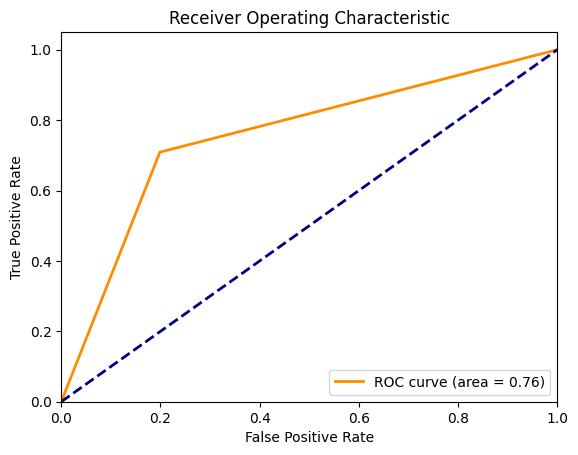

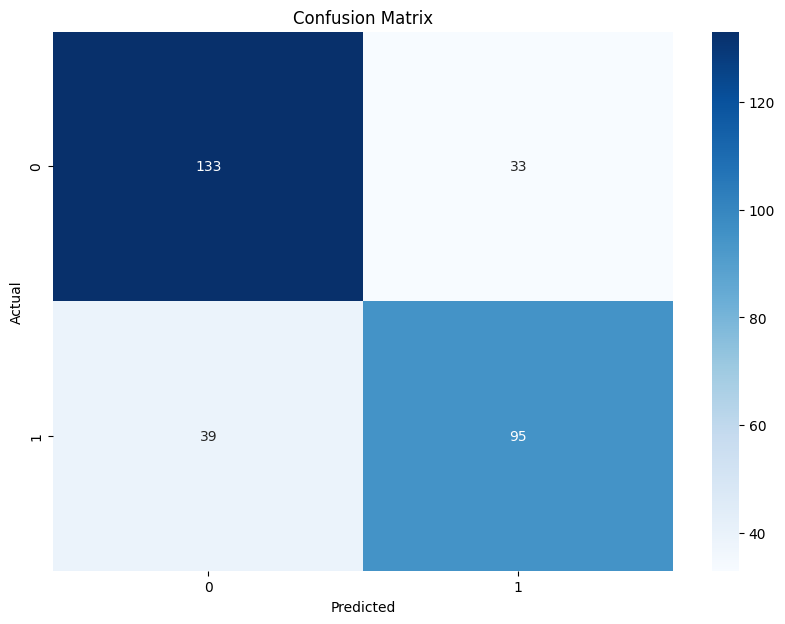

In [20]:
final_prediction, predictions = classifier.predict(X_test)

# Mostrar resultados
print("Accuracy:", accuracy_score(y_test.any(axis=1), final_prediction))
print("Classification Report:\n", classification_report(y_test.any(axis=1), final_prediction))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test.any(axis=1), final_prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test.any(axis=1), final_prediction)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
skf = StratifiedKFold(n_splits=5)

# Diccionario para almacenar los puntajes de validación cruzada
cross_val_scores = {}

# Iterar sobre cada modelo en classifier.models
for label in classifier.label_columns:
    model = classifier.models[label]
    scores = cross_val_score(model, X, y[label], cv=skf, scoring='accuracy')
    cross_val_scores[label] = scores
    print(f"Cross-validation scores for {label}: {scores}")
    print(f"Mean cross-validation score for {label}: {np.mean(scores)}")

# Mostrar los puntajes de validación cruzada para todos los modelos
print("Cross-validation scores for all models:", cross_val_scores)

Cross-validation scores for IsAbusive: [0.735 0.75  0.795 0.78  0.725]
Mean cross-validation score for IsAbusive: 0.7569999999999999
Cross-validation scores for IsProvocative: [0.84  0.84  0.885 0.815 0.855]
Mean cross-validation score for IsProvocative: 0.8469999999999999
Cross-validation scores for IsHatespeech: [0.795 0.83  0.8   0.845 0.78 ]
Mean cross-validation score for IsHatespeech: 0.8099999999999999
Cross-validation scores for IsRacist: [0.83  0.89  0.865 0.885 0.865]
Mean cross-validation score for IsRacist: 0.867
Cross-validation scores for all models: {'IsAbusive': array([0.735, 0.75 , 0.795, 0.78 , 0.725]), 'IsProvocative': array([0.84 , 0.84 , 0.885, 0.815, 0.855]), 'IsHatespeech': array([0.795, 0.83 , 0.8  , 0.845, 0.78 ]), 'IsRacist': array([0.83 , 0.89 , 0.865, 0.885, 0.865])}


In [23]:
def predict_text(classifier, text):
    processed_text = classifier.preprocess_text(text)
    
    # Hacer la predicción
    final_prediction, predictions = classifier.predict(processed_text)
    
    # Mostrar las predicciones
    print("Final Prediction (any label):", final_prediction)
    for label, prediction in predictions.items():
        print(f"Prediction for {label}: {prediction}")
    
    return predictions

In [28]:
text = "I love Donald Trump"
predictions = predict_text(classifier, text)

Final Prediction (any label): [False]
Prediction for IsAbusive: [0]
Prediction for IsProvocative: [0]
Prediction for IsHatespeech: [0]
Prediction for IsRacist: [0]


In [30]:
import joblib

joblib.dump(classifier, 'multihead_hate_classifier_BERT.pkl')

['multihead_hate_classifier_BERT.pkl']